# Action Recognition

This notebook contains the main code for the action recognition task. It loads the participant data, preprocesses it and uses this data to train the different models.

### Import librairies

In [1]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *
from models.DeepModels import *
from models.DeepUtils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant
from torch.utils.data import DataLoader

random.seed(RANDOM_STATE)

### Data loading

Change here the participant to load.

In [2]:
part_name = 's6'
use_saved = True

In [3]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [4]:
test_size = 0.3
pca_expl_var = 0.95

<span style='color: red'>WARNING</span>: computing all features takes around 9 minutes (Intel Core i7-7700K)

In [5]:
if use_saved and os.path.exists(f'saved/features_{part_name}_ExObs.h5'):
    features = pd.read_hdf(f'saved/features_{part_name}_ExObs.h5', 'df')
else:
    features = participant.get_features_all_sessions_ExObs()
    features.to_hdf(f'saved/features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)

In [6]:
print(f'The dataset contains {features.shape[0]} samples and {features.shape[1]} features.')
print(f'The {len(participant.relevant_channels_both)} relevant channels are located in the following locations:')
regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_both]]
channels_per_regions = {}
for region in set(regions):
    channels_per_regions[region] = regions.count(region)
print(channels_per_regions)

The dataset contains 256 samples and 2881 features.
The 40 relevant channels are located in the following locations:
{'insula': 3, 'paracentral': 1, 'postcentral': 9, 'caudalmiddlefrontal': 4, 'precentral': 13, 'superiorfrontal': 5, 'WM_precentral': 5}


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [7]:
use_saved = True

In [8]:
if use_saved and os.path.exists(f'saved/baseline_features_{part_name}_ExObs.h5'):
    baseline_features = pd.read_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df')
else:
    baseline_features = participant.get_features_all_sessions_unresponsive(movtype=None)
    baseline_features.to_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)

In [9]:
print(f'The baseline dataset contains {baseline_features.shape[0]} samples and {baseline_features.shape[1]} features.')

The baseline dataset contains 256 samples and 2737 features.


In [10]:
accuracies = {}
accuracies_baseline = {}

### Possible hyperparameters for MLP models.

In [23]:
models = {
    '8_8_01': {
        'layers': (8, 8),
        'lr': 0.1
    },
    '8_16_01': {
        'layers': (8, 16),
        'lr': 0.1
    },
    '16_16_01': {
        'layers': (16, 16),
        'lr': 0.1
    },
    '32_16_01': {
        'layers': (32, 16),
        'lr': 0.1
    }
}

### Train a model on the baseline features (Logistic Regression)

In [12]:
X = baseline_features.drop('label', axis=1)
y = baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['Logistic Regression'] = accuracy

Accuracy: 0.68


#### With PCA

In [13]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['Logistic Regression PCA'] = accuracy

Accuracy: 0.61


### Train a model (SVM)

In [14]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['SVM'] = accuracy

Accuracy: 0.65


#### With PCA

In [15]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['SVM PCA'] = accuracy

Accuracy: 0.66


### Train a model (Random Forest)

In [16]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['Random Forest'] = accuracy

Accuracy: 0.66


### Train a model (Multi-Layer Perceptron)

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=4)

    trainer = Trainer(mlp, params['lr'], 10, 4, save_path=f'saved/mlpARbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.6924
Model 8_16_01 Validation Loss: 0.6936
Model 16_16_01 Validation Loss: 0.6946
Model 32_16_01 Validation Loss: 0.6941
Model 32_16_05 Validation Loss: 55358084.6316


The best model has 2 layers of 8 neurons and a learning rate of 0.1.

In [ ]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpARbaseline_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_baseline['MLP'] = acc

Accuracy: 0.51


## Let's now do the analysis for the responsive channels

In [19]:
X = features.drop('label', axis=1)
y = features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [20]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['Logistic Regression'] = accuracy

Accuracy: 0.99


#### With PCA

In [21]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['Logistic Regression PCA'] = accuracy

Accuracy: 1.00


### Train a model (SVM)

In [22]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['SVM'] = accuracy

Accuracy: 0.99


#### With PCA

In [23]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['SVM PCA'] = accuracy

Accuracy: 0.99


### Train a model (Random Forest)

In [24]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['Random Forest'] = accuracy

Accuracy: 0.99


### Train a model (Multi-Layer Perceptron)

In [22]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)
    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpAR_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.6807
Model 8_16_01 Validation Loss: 0.6877
Model 16_16_01 Validation Loss: 0.7000
Model 32_16_01 Validation Loss: 0.6844


In [25]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpAR_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies['MLP'] = acc

Accuracy: 0.45


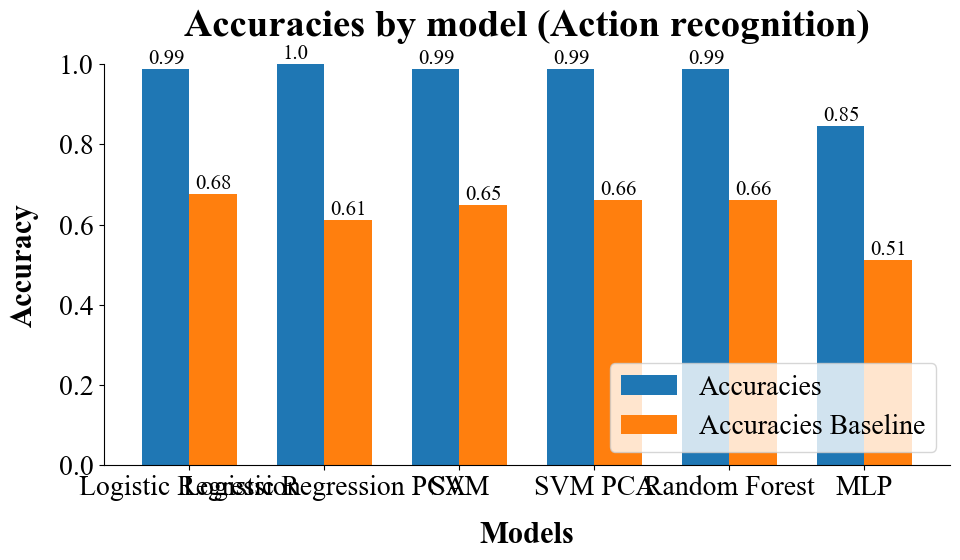

In [ ]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies.keys()

dataset_values = [accuracies[model] for model in models]
baseline_values = [accuracies_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (Action recognition)')

ax.set_ylim(0,1)

ax.legend(loc = 'lower right')

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_ExObs.png')
plt.show()